<a href="https://colab.research.google.com/github/adityadhumal06/Keras_Functional_Models/blob/main/Multi_Output_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# dataset link - https://www.kaggle.com/datasets/jangedoo/utkface-new

In [2]:
!kaggle datasets download -d jangedoo/utkface-new

 99% 329M/331M [00:02<00:00, 159MB/s]
100% 331M/331M [00:02<00:00, 126MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/utkface-new.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


In [5]:
folder_path = '/content/utkface_aligned_cropped/UTKFace'

In [6]:
age = []
gender = []
img = []

for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img.append(file)

In [7]:
len(age)

23708

In [8]:
import pandas as pd
df = pd.DataFrame({'age':age,'gender':gender,'image':img})

In [9]:
df

,age,gender,image
0,37,0,37_0_3_20170109134008515.jpg.chip.jpg
1,4,1,4_1_0_20170109192418427.jpg.chip.jpg
2,62,0,62_0_2_20170112223958141.jpg.chip.jpg
3,54,0,54_0_3_20170119200606516.jpg.chip.jpg
4,1,1,1_1_3_20161220220548777.jpg.chip.jpg
...,...,...,...
23703,31,0,31_0_1_20170116024204398.jpg.chip.jpg
23704,26,1,26_1_1_20170112213007903.jpg.chip.jpg
23705,28,0,28_0_3_20170104214745317.jpg.chip.jpg
23706,35,0,35_0_0_20170117145704297.jpg.chip.jpg


In [10]:
df.shape

(23708, 3)

In [11]:
train_ds = df.sample(frac=1,random_state=0).iloc[:20000]
test_ds = df.sample(frac=1,random_state=0).iloc[20000:]

In [12]:
train_ds.shape

(20000, 3)

In [13]:
test_ds.shape

(3708, 3)

In [14]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(
    rescale=1./255)

In [15]:
train_data_generator = train_datagen.flow_from_dataframe(train_ds,
                                                         directory=folder_path,
                                                         x_col='image',
                                                         y_col = ['age','gender'],
                                                         target_size=(256,256),
                                                         class_mode = 'multi_output')


test_data_generator = train_datagen.flow_from_dataframe(test_ds,
                                                         directory=folder_path,
                                                         x_col='image',
                                                         y_col = ['age','gender'],
                                                         target_size=(256,256),
                                                         class_mode = 'multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [16]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [17]:
vggnet = VGG16(include_top=False , input_shape=(256,256,3))

58889256/58889256 [==============================] - 0s 0us/step


In [27]:
vggnet.trainable = False

output = vggnet.layers[-1].output # last layer consider will be output

flatten = Flatten()(output)

dense1 = Dense(512,activation='relu')(flatten)
dense2 = Dense(512,activation='relu')(flatten)

dense3 = Dense(512,activation='relu')(dense1)
dense4 = Dense(512,activation ='relu')(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

In [28]:
model = Model(inputs=vggnet.input,outputs = [output1,output2]) # same input as vggnet model

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

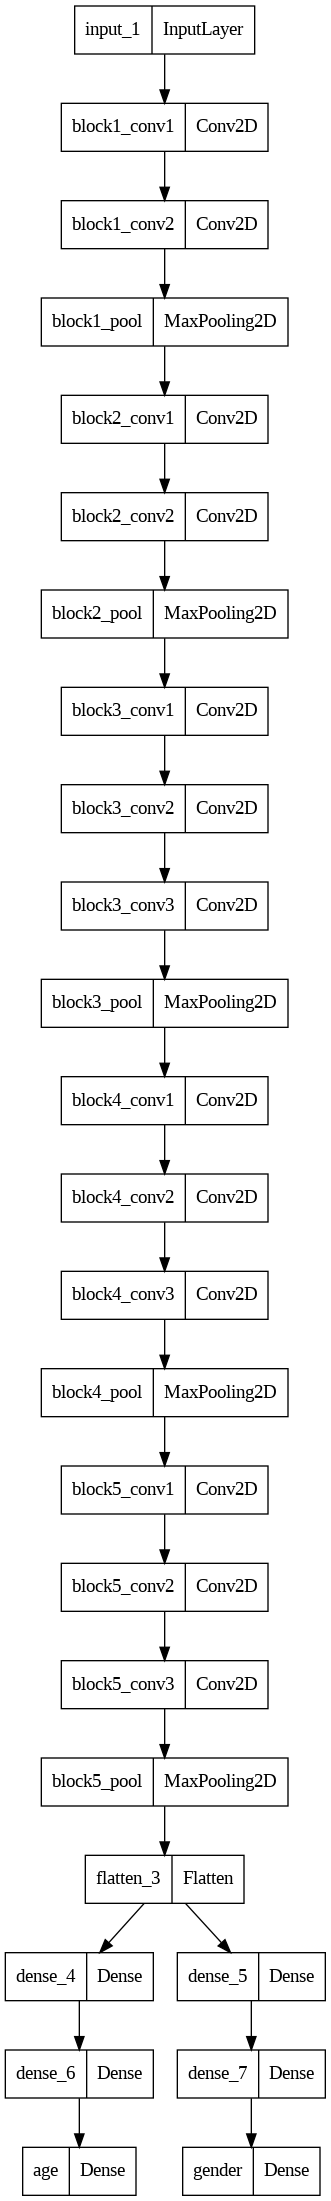

In [30]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [31]:
model.compile(optimizer='adam',loss={'age':'mae','gender':'binary_crossentropy'},metrics={'age':'mae','gender':'accuracy'})

In [32]:
history = model.fit(train_data_generator,validation_data=test_data_generator,epochs=1,batch_size=32)

625/625 [==============================] - 423s 650ms/step - loss: 12.0100 - age_loss: 11.4371 - gender_loss: 0.5729 - age_mae: 11.4371 - gender_accuracy: 0.7266 - val_loss: 11.5811 - val_age_loss: 10.9786 - val_gender_loss: 0.6026 - val_age_mae: 10.9786 - val_gender_accuracy: 0.6189
